In [7]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from src.VQVAE_monai import VQVAE
from src.Dataset import AudioMNIST
from src.TransformerMonai import *
from src.Classifier import AudioClassifier
import torchattacks
import pickle

In [8]:
# Paths
CODE_ROOT = os.path.expanduser("~/Audio-MNIST-Generation/run")
DATA_ROOT = "/home/dl_class/Audio-MNIST-Generation/Data"
SAVE_DIR = "/mnt/dl_Spring25/durga"  
os.makedirs(SAVE_DIR, exist_ok=True)

In [9]:
os.getcwd()

'/home/durga/Audio-MNIST-Generation/run'

In [10]:
# Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqvae = torch.load(f"{SAVE_DIR}/saved_models/vqvae_monai.pth", map_location=device).to(device)
transformer = torch.load(f"{SAVE_DIR}/saved_models/MONAI_Cond2_Transformer_epochs_50.pt", map_location=device).to(device)

/tmp/ipykernel_1851975/2545358624.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae = torch.load(f"{SAVE_DIR}/saved_models/vqvae_monai.pth", map_location=device).to(

In [11]:
from src.Classifier import AudioClassifier
classifier = AudioClassifier()  # or whatever model class is used

# Load the weights into the model
state_dict = torch.load(f"{SAVE_DIR}/models/audio_classifier.pt", map_location=device)
classifier.load_state_dict(state_dict)

# We Move model to the correct device
classifier = classifier.eval().to(device)

/tmp/ipykernel_1851975/563754576.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{SAVE_DIR}/models/audio_classifier.pt", map_location=device)


In [12]:
from src.AudioMNISTDataset import AudioMNIST # assumes similar class exists
from src.custom_transforms import TrimSilence, FixLength
import torchvision.transforms as T
transforms = [TrimSilence(5), FixLength(16000)]

dataset = AudioMNIST(
    root=DATA_ROOT, 
    transform=T.Compose(transforms)
)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

class AttackTwinDataset(Dataset):
    def __init__(self, data_ds, classifier_model, attack_type="FGSM",
epsilon=0.01, alpha=0.001, steps=10):
        super().__init__()
        self.dataset = []
        
        self.classifier_model = classifier_model.eval()
        if attack_type == "FGSM":
            self.attack = torchattacks.FGSM(classifier_model, eps=epsilon)
        elif attack_type == "PGD":
            self.attack = torchattacks.PGD(classifier_model, eps=epsilon,
            alpha=alpha, steps=steps)
        else:
            raise ValueError(f"Unknown attack type: {attack_type}")
        for datapt, label in tqdm(data_ds, desc=f"Generating {attack_type} attacks"):
            with torch.no_grad():
                if label == -1:
                    continue
            #Here we print(label)
            a_s= self.attack(datapt,label)
            self.dataset.append((datapt, a_s, label))
       

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
        

In [13]:
atk_dataset = AttackTwinDataset(data_loader, classifier)
torch.save(atk_dataset, f"{SAVE_DIR}/attacked_dataset_eps001.pt")

Generating FGSM attacks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [04:58<00:00, 100.56it/s]


In [14]:
real_latents = []
attacked_latents = []
labels = []
for orig, atk, lbl in tqdm(atk_dataset):
    #print(orig.shape,atk.shape,lbl.shape)
    #print(atk.unsqueeze(0).flatten(1).shape,orig.unsqueeze(0).flatten(1).shape)
    #break
    orig, atk = orig.to(device), atk.to(device)
    #atk = atk.mean(dim=1, keepdim=True)  # Shape becomes [1, 1, 128, 44]
    #orig = orig.mean(dim=1, keepdim=True)
    a_l = vqvae.model.index_quantize(atk).flatten(1).detach().cpu().numpy()
    r_l = vqvae.model.index_quantize(orig).flatten(1).detach().cpu().numpy()
    attacked_latents.append(a_l.squeeze())
    real_latents.append(r_l.squeeze())
    labels.append(lbl.item())

with open(f"{SAVE_DIR}/attacked_latents.pkl", "wb") as f:
    pickle.dump((attacked_latents, labels), f)

  0%|                                                                                                                                                                                    | 0/30000 [00:00<?, ?it/s]/home/durga/Audio-MNIST-Generation/GenerativeModels/generative/networks/layers/vector_quantizer.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/durga/Audio-MNIST-Generation/GenerativeModels/generative/networks/layers/vector_quantizer.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [07:29<00:00, 66.67it/s]


In [58]:
len(atk_dataset)

30000

In [26]:
fake_attacked_latents = []
transformer.eval()

BOS_TOKEN = 256
max_tokens = 352

with torch.no_grad():
    for lbl in tqdm(np.unique(labels), desc="Generating fake attacked latents"):
        # Createating input of context: [BOS_TOKEN, BOS_TOKEN + 1 + label]
        context = torch.tensor([[BOS_TOKEN, BOS_TOKEN + 1 + lbl]], device=device)

        # Generateating fake latent VQVAE indices from transformer
        output = transformer.generate(context, max_new_tokens=max_tokens)

        # Remove BOS and label from beginning
        fake_latents = output[0, 2:]  # Shape: (352,)
        fake_attacked_latents.append(fake_latents.cpu().numpy())

# Here we Stack and save
fake_attacked_latents = np.stack(fake_attacked_latents)
np.save(f"{SAVE_DIR}/fake_attacked_latents.npy", fake_attacked_latents)


Generating fake attacked latents: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


In [30]:
f_a_l.shape

torch.Size([352])

In [31]:
fake_specs = []

for f_a_l in fake_attacked_latents:
    f_a_l = torch.tensor(f_a_l).long().to(device).view(1, 32, 11)  # [B, D, H]
    
    with torch.no_grad():
        f_a_s = vqvae.model.decode_samples(f_a_l)  # Output: [B, C, H, W]
    
    fake_specs.append(f_a_s.squeeze(0).cpu().numpy())  # [C, H, W]

np.save(f"{SAVE_DIR}/fake_spectrograms.npy", fake_specs)

In [34]:
correct = 0
total = 0

classifier.eval()  # Ensure the classifier is in eval mode

for _, atk, lbl in tqdm(atk_dataset, desc="Evaluating FGSM examples"):
    atk, lbl = atk.to(device), lbl.to(device)
    with torch.no_grad():
        pred = classifier(atk)
    if pred.argmax(dim=1).item() == lbl.item():
        correct += 1
    total += 1

print("FGSM accuracy (epsilon=0.01):", correct / total)


Evaluating FGSM examples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [02:10<00:00, 230.08it/s]

FGSM accuracy (epsilon=0.01): 0.49716666666666665


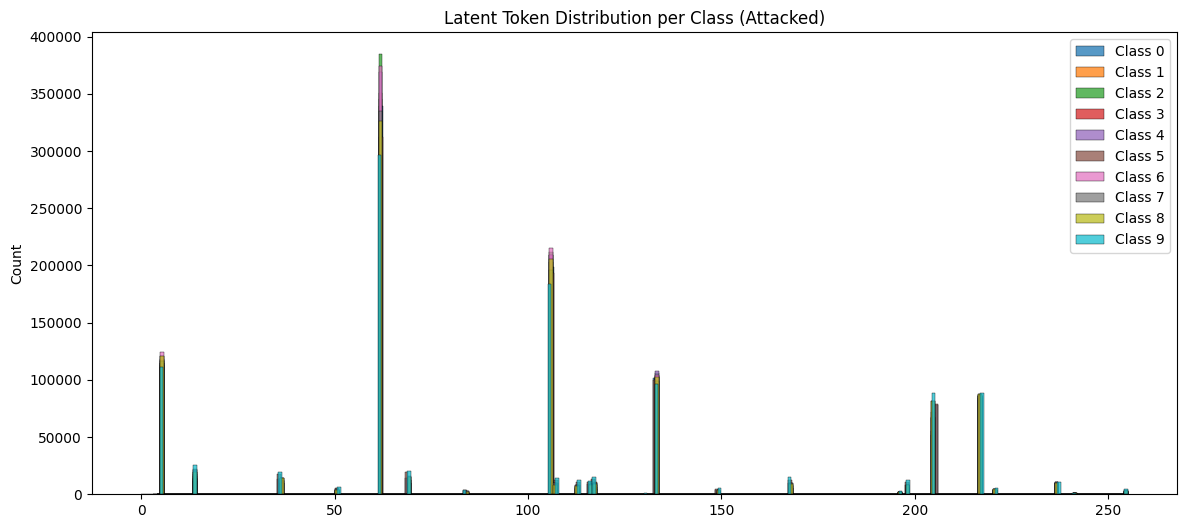

In [36]:
import seaborn as sns
from collections import defaultdict

class_latents = defaultdict(list)
for lat, lbl in zip(attacked_latents, labels):
    class_latents[lbl].extend(lat)

plt.figure(figsize=(14, 6))
for i in range(10):
    sns.histplot(class_latents[i], bins=267, label=f"Class {i}", kde=False)
plt.legend()
plt.title("Latent Token Distribution per Class (Attacked)")
plt.savefig(f"{SAVE_DIR}/latent_histograms.png")

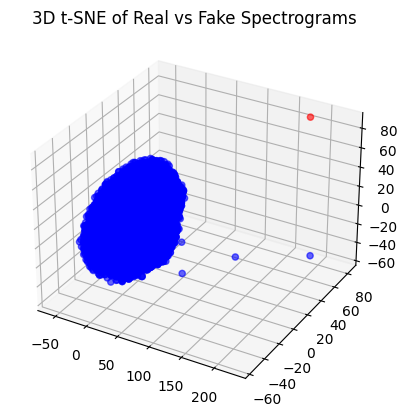

In [39]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"



# 3D PCA or t-SNE on specs
all_specs = [atk.cpu().numpy().flatten() for _, atk, _ in atk_dataset] + [f.flatten() for f in fake_specs]
labels_spec = ["real"] * len(atk_dataset) + ["fake"] * len(fake_specs)

X = np.array(all_specs)
Z = TSNE(n_components=3).fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2],
           c=["blue" if l == "real" else "red" for l in labels_spec], alpha=0.6)

plt.title("3D t-SNE of Real vs Fake Spectrograms")
plt.savefig(f"{SAVE_DIR}/tsne_3d_plot.png")
